In [14]:
import re
import unicodedata
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
def read_text(filename):
    file = open(filename, mode='rt', encoding='utf-8')

    text = file.read()
    file.close()
    return text

In [16]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [17]:
data = read_text('deu.txt')
deu_eng = to_lines(data)
deu_eng = np.array(deu_eng)

In [18]:
deu_eng = deu_eng[:60000, :]
deu_eng[:3]

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)']],
      dtype='<U537')

In [19]:
import string

# 구두점 제거
deu_eng[:, 0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:, 0]]
deu_eng[:, 1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:, 1]]

print(deu_eng[:5, :2])

[['Go' 'Geh']
 ['Hi' 'Hallo']
 ['Hi' 'Grüß Gott']
 ['Run' 'Lauf']
 ['Run' 'Lauf']]


In [20]:
# 소문자 변환
for i in range(len(deu_eng)):
    deu_eng[i, 0] = deu_eng[i, 0].lower()
    deu_eng[i, 1] = deu_eng[i, 1].lower()

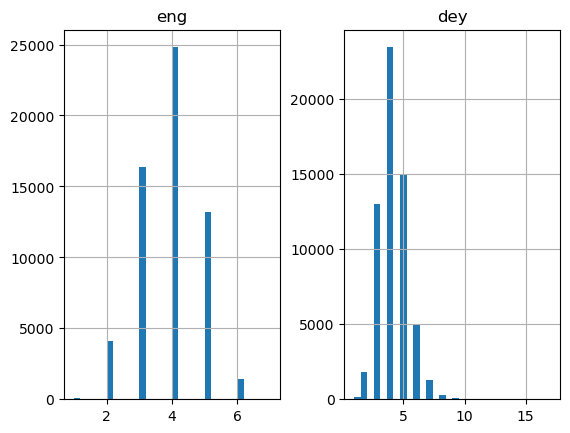

In [21]:
import matplotlib.pyplot as plt

eng_1 = []
deu_1 = []

for i in deu_eng[:, 0]:
    eng_1.append(len(i.split()))

for i in deu_eng[:, 1]:
    deu_1.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_1, 'dey':deu_1})

length_df.hist(bins=30)
plt.show()

In [9]:
# 숙제
# 토큰화 -> 패딩 -> train/test 분리
# 인코더, 디코더 모델 설계 -> 학습 -> 결과

In [10]:
# tokenizer 초기화
tokenizer_eng = Tokenizer()
tokenizer_deu = Tokenizer()

In [11]:
# 토큰화
tokenizer_eng.fit_on_texts(deu_eng[:, 1])
tokenizer_deu.fit_on_texts(deu_eng[:, 0])

In [12]:
# 텍스트 -> 시퀀스 변환
sequences_eng = tokenizer_eng.texts_to_sequences(deu_eng[:, 1])
sequences_deu = tokenizer_deu.texts_to_sequences(deu_eng[:, 0])

In [100]:
# 최대 시퀀스 길이(패딩 적용을 위한 사전준비)
max_len_eng = max([len(l) for l in sequences_eng])
max_len_deu = max([len(l) for l in sequences_deu])

In [101]:
# 패딩
padded_eng = pad_sequences(sequences_eng, maxlen=max_len_eng, padding='post')
padded_deu = pad_sequences(sequences_deu, maxlen=max_len_deu, padding='post')

In [102]:
print(padded_eng.shape, padded_deu.shape)

(60000, 17) (60000, 7)


In [103]:
# train/test 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_deu, padded_eng, test_size=0.2, random_state=42)

In [104]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(48000, 7) (12000, 7)
(48000, 17) (12000, 17)


In [105]:
# 디코더 입력/목표 데이터 준비
decoder_input_train = y_train[:, :-1]
decoder_target_train = y_train[:, 1:]

decoder_input_test = y_test[:, :-1]
decoder_target_test = y_test[:, 1:]

In [106]:
decoder_target_train = np.expand_dims(decoder_target_train, -1)
decoder_target_test = np.expand_dims(decoder_target_test, -1)

In [107]:
print(X_train.shape)

(48000, 7)


In [108]:
print(decoder_input_train.shape)

(48000, 16)


In [109]:
print(decoder_target_train.shape)

(48000, 16, 1)


In [110]:
import warnings
warnings.filterwarnings(action='ignore')

In [111]:
# 인코더/디코더 모델 설계
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, GRU

embedding_dim = 256
units = 512
vocab_size_deu = len(tokenizer_deu.word_index)+1
vocab_size_eng = len(tokenizer_eng.word_index)+1

encoder_inputs = tf.keras.Input(shape=(None,))
encoder_embedding = Embedding(vocab_size_deu, embedding_dim)(encoder_inputs)
encoder_gru = GRU(units, return_state=True)
encoder_outputs, encoder_state = encoder_gru(encoder_embedding)

decoder_inputs = tf.keras.Input(shape=(None,))
decoder_embedding = Embedding(vocab_size_eng, embedding_dim)(decoder_inputs)
decoder_gru = GRU(units, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_gru(decoder_embedding, initial_state=encoder_state)

decoder_dense = Dense(vocab_size_eng, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

2024-07-15 22:52:38.838151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-15 22:52:38.838733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-15 22:52:38.839267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [112]:
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [113]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [114]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, None, 256)    1770240     ['input_13[0][0]']               
                                                                                                  
 embedding_13 (Embedding)       (None, None, 256)    2986240     ['input_14[0][0]']               
                                                                                            

In [115]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [117]:
history = model.fit(x=[X_train, decoder_input_train], y=decoder_target_train, batch_size=128, epochs=10, 
    validation_data=([X_test, decoder_input_test], decoder_target_test), callbacks=[es, mc])

Epoch 1/10
375/375 [==============================] - ETA: 0s - loss: 1.3937 - acc: 0.8099

2024-07-15 22:59:36.147984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-15 22:59:36.148629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-15 22:59:36.149404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_acc improved from -inf to 0.81651, saving model to best_model.h5
375/375 [==============================] - 431s 1s/step - loss: 1.3937 - acc: 0.8099 - val_loss: 1.2654 - val_acc: 0.8165
Epoch 2/10
375/375 [==============================] - ETA: 0s - loss: 1.1194 - acc: 0.8300
Epoch 2: val_acc improved from 0.81651 to 0.84110, saving model to best_model.h5
375/375 [==============================] - 388s 1s/step - loss: 1.1194 - acc: 0.8300 - val_loss: 1.0334 - val_acc: 0.8411
Epoch 3/10
375/375 [==============================] - ETA: 0s - loss: 0.8643 - acc: 0.8560
Epoch 3: val_acc improved from 0.84110 to 0.86617, saving model to best_model.h5
375/375 [==============================] - 352s 939ms/step - loss: 0.8643 - acc: 0.8560 - val_loss: 0.8182 - val_acc: 0.8662
Epoch 4/10
375/375 [==============================] - ETA: 0s - loss: 0.6318 - acc: 0.8828
Epoch 4: val_acc improved from 0.86617 to 0.88752, saving model to best_model.h5
375/375 [===========================

In [118]:
# 모델 평가
loss = model.evaluate([X_test, decoder_input_test], decoder_target_test)
print(f'Test loss: {loss}')

375/375 [==============================] - 39s 105ms/step - loss: 0.5092 - acc: 0.9200
Test loss: [0.5092310905456543, 0.9199844002723694]


In [13]:
# 강사님 코드

In [24]:
deu_eng[:,0]

array(['go', 'hi', 'hi', ..., 'tom can sing very well',
       'tom can swim very fast', 'tom can swim very well'], dtype='<U537')

In [23]:
deu_eng[:,1]

array(['geh', 'hallo', 'grüß gott', ..., 'tom kann sehr gut singen',
       'tom kann sehr schnell schwimmen', 'tom kann sehr gut schwimmen'],
      dtype='<U537')

In [25]:
# deu_eng : 독일어와 영어가 섞여있는 변수

In [31]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import optimizers

In [32]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [33]:
eng_tokenizer = tokenization(deu_eng[:,0])
eng_vocab_size = len(eng_tokenizer.word_index)+1

print('English Voabulary Size : ', eng_vocab_size)

English Voabulary Size :  6915


In [34]:
deu_tokenizer = tokenization(deu_eng[:,1])
deu_vocab_size = len(deu_tokenizer.word_index)+1

print('Deutch Vocabulary Size : ', deu_vocab_size)

Deutch Vocabulary Size :  11665


In [38]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [39]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(deu_eng, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(deu_eng[:,0], deu_eng[:,1], test_size=0.2, random_state=42)

In [40]:
# 어떤 것을 학습시켜서 어떤 것을 예측할 것인가
deu_length = 10
eng_length = 8

X_train = encode_sequences(deu_tokenizer, deu_length, train[:,1])
y_train = encode_sequences(eng_tokenizer, eng_length, train[:,0])

X_test = encode_sequences(deu_tokenizer, deu_length, test[:,1])
y_test = encode_sequences(eng_tokenizer, eng_length, test[:,0])

In [41]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(48000, 10) (12000, 10)
(48000, 8) (12000, 8)


In [46]:
# 디코더 입력/목표 데이터 준비
decoder_input_train = y_train[:, :-1]
decoder_target_train = y_train[:, 1:]

decoder_input_test = y_test[:, :-1]
decoder_target_test = y_test[:, 1:]

In [47]:
decoder_input_train[:3]

array([[  44,  143,   10,    2,  356,    3,    0],
       [  36,   72, 4451,    0,    0,    0,    0],
       [   1,   41, 1618,    0,    0,    0,    0]], dtype=int32)

In [48]:
decoder_target_train[:3]

array([[ 143,   10,    2,  356,    3,    0,    0],
       [  72, 4451,    0,    0,    0,    0,    0],
       [  41, 1618,    0,    0,    0,    0,    0]], dtype=int32)

In [49]:
y_train[:3]

array([[  44,  143,   10,    2,  356,    3,    0,    0],
       [  36,   72, 4451,    0,    0,    0,    0,    0],
       [   1,   41, 1618,    0,    0,    0,    0,    0]], dtype=int32)

In [50]:
print(decoder_input_train.shape, decoder_target_train.shape)
print(decoder_input_test.shape, decoder_target_test.shape)

(48000, 7) (48000, 7)
(12000, 7) (12000, 7)


In [51]:
import numpy as np

sos_token = 1
eos_token = 2

def add_tokens(y, sos_token, eos_token):
    sos = np.full((y.shape[0], 1), sos_token)
    eos = np.full((y.shape[0], 1), eos_token)

    y = np.concatenate([sos, y, eos], axis=1)
    return y

In [52]:
decoder_input = add_tokens(y_train, sos_token, eos_token)

print(decoder_input.shape)

(48000, 10)


In [53]:
decoder_input

array([[   1,   44,  143, ...,    0,    0,    2],
       [   1,   36,   72, ...,    0,    0,    2],
       [   1,    1,   41, ...,    0,    0,    2],
       ...,
       [   1,   11, 1220, ...,    0,    0,    2],
       [   1,   12,    4, ...,    0,    0,    2],
       [   1,    2,   45, ...,    0,    0,    2]])

In [57]:
from tensorflow.keras.layers import Input, Embedding, LSTM
import tensorflow as tf

embedding_dim = 64
hidden_units = 64

In [58]:
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(deu_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(hidden_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

2024-07-16 10:28:19.470372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-16 10:28:19.471720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-16 10:28:19.472488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [61]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(eng_vocab_size, hidden_units)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

decoder_dense = Dense(eng_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

2024-07-16 10:32:07.674385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-16 10:32:07.675212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-16 10:32:07.676018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [62]:
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [63]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [65]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [66]:
history = model.fit(x=[X_train, decoder_input_train], y=decoder_target_train, batch_size=128, epochs=10,
                    validation_data=([X_test, decoder_input_test], decoder_target_test), callbacks=[es, mc])

Epoch 1/10


2024-07-16 10:35:40.929865: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-16 10:35:41.064420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-16 10:35:41.065233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-16 10:35:41.065986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

375/375 [==============================] - ETA: 0s - loss: 3.4998 - acc: 0.5906

2024-07-16 10:36:30.720196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-16 10:36:30.720954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-16 10:36:30.721886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_acc improved from -inf to 0.60238, saving model to best_model.h5
375/375 [==============================] - 56s 147ms/step - loss: 3.4998 - acc: 0.5906 - val_loss: 2.6915 - val_acc: 0.6024
Epoch 2/10
375/375 [==============================] - ETA: 0s - loss: 2.5889 - acc: 0.6141
Epoch 2: val_acc improved from 0.60238 to 0.62067, saving model to best_model.h5
375/375 [==============================] - 58s 156ms/step - loss: 2.5889 - acc: 0.6141 - val_loss: 2.5186 - val_acc: 0.6207
Epoch 3/10
375/375 [==============================] - ETA: 0s - loss: 2.3911 - acc: 0.6272
Epoch 3: val_acc improved from 0.62067 to 0.63214, saving model to best_model.h5
375/375 [==============================] - 55s 148ms/step - loss: 2.3911 - acc: 0.6272 - val_loss: 2.3269 - val_acc: 0.6321
Epoch 4/10
375/375 [==============================] - ETA: 0s - loss: 2.1962 - acc: 0.6427
Epoch 4: val_acc improved from 0.63214 to 0.64655, saving model to best_model.h5
375/375 [========================

In [67]:
print('Test Acc : ', model.evaluate([X_test, decoder_input_test], decoder_target_test))

375/375 [==============================] - 9s 24ms/step - loss: 1.5903 - acc: 0.7226
Test Acc :  [1.5903270244598389, 0.7226428389549255]


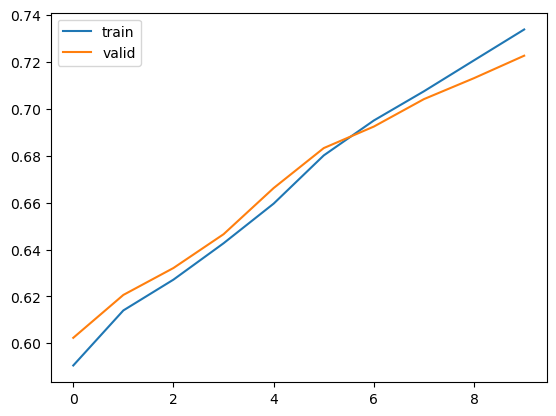

In [68]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train', 'valid'])
plt.show()